# Quantum mechanical data assimilation of Lorenz 96 multiscale

In [1]:
%load_ext nb_mypy
%nb_mypy On
    
%matplotlib ipympl

Version 1.0.4


In [2]:
import matplotlib.pyplot as plt
import nlsa.function_algebra as fun
import nlsa.matrix_algebra as mat
import nlsa.vector_algebra as vec
import numpy as np
import scipy.linalg as la

from dataclasses import dataclass
from functools import partial
from ipywidgets import interact, IntSlider
from itertools import islice
from mat73 import loadmat
from more_itertools import take
from multiprocess import Pool
from nlsa.abstract_algebra import id_map, iterate, multiply_by
from nlsa.dynamics import cocycle_orbit
from nlsa.function_algebra import compose, compose2
from nlsa.qmda import make_da, pure_state_prediction, Qmda
from nlsa.quantum_circuits import ensemble_measurement, koopman_circuit
from os.path import join
from typing import TypeVar
from nptyping import Int, NDArray, Shape

In [3]:
@dataclass
class Nlsa:
    """Class for keeping track of NLSA parameters for L96 multiscale system.
    
    """
    # Parameters to be set by user
    F: float # Forcing parameter
    epsilon: float # Timesscale parameter for fast variables
    dt: float # Sampling interval
    nS: int # Number of training samples
    nSOut: int # Number of test samples
    idxXSrc: NDArray[Shape["NX"], Int] # State vector components to use for training 
    idxXObs: NDArray[Shape["NXO"], Int] # State vector components for observations
    embWindow: int # Delay embedding window
    kernel: str # Kernel type
    ifDen: bool # Set true to use variable-bandwidth kernel  
    
    # Parameters with default values
    nX: int = 9 # slow variables
    nY: int = 8 # fast variables
    hX: float = -0.8 # Coupling parameter from slow to fast variables
    hY: float = 1.0 # Coupling parameter from fast to slow variables    
    nSSpin: int = 10000 # Number of spinup samples
    x0: float  = 1     # Initial conditions for slow variables (training data)
    y0: float  = 1     # Initial conditions for fast variables (training data)
    x0Out: float = 1.2  # Initial conditions for slow variables (test data)
    y0Out: float = 1.2  # Initial conditions for fast variables (test data)
    absTol: float = 1E-7 # Absolute tolerance for ODE solver
    relTol: float = 1E-5 # Relative tolerance for ODE solver
        
    
    def tag(self) -> str:
        s = f'F{self.F:.1f}'\
          + f'_eps{self.epsilon:.3g}'\
          + f'_dt{self.dt:.2g}'\
          + f'_nS{self.nS}'\
          + f'_nSOut{self.nSOut}'\
          + f'_idxXSrc1-+1-{self.idxXSrc[-1]}'\
          + f'_idxXObs1-+1-{self.idxXObs[-1]}'\
          + f'_emb{self.embWindow}'\
          + '_' + self.kernel
        if self.ifDen:
            s += '_den'
        return s

In [4]:
#Set up NLSA and QMDA parameters
nlsa_model = Nlsa(F=10,
                  epsilon=1 / 128,
                  dt=0.05,
                  nS=40000,
                  nSOut=7000,
                  idxXSrc=np.arange(1, 9 + 1),
                  idxXObs=np.arange(1, 9 + 1),
                  embWindow=1,
                  kernel='l2',
                  ifDen=True)

qmda_model =Qmda(nTO=1,
                 nTF=100, 
                 nL=1024, 
                 shape_fun="bump", 
                 epsilon=0.6)

In [5]:
# import data
path = './figs'
path = join(path, nlsa_model.tag(), qmda_model.tag())

qmda_data = \
    {'u': loadmat(join(path, 'u.mat'), only_include='U_sav')['U_sav'],
     'm': loadmat(join(path, 'm.mat'), only_include='M')['M'],
     'm_eval': loadmat(join(path, 'm.mat'), only_include='MEval')['MEval'],
     'm_evec': loadmat(join(path, 'm.mat'), only_include='MEvec')['MEvec'],
     'k': loadmat(join(path, 'k.mat'), only_include='K_sav')['K_sav'],
     'y': loadmat(join(path, 'y.mat'), only_include='yRef')['yRef']
    }

In [6]:
q = 10 # number of qubits
n_obs = 200 # number of data assimilation observations
n_pred = 100 # number of prediction timesteps

n = 2 ** q

u, _ = la.polar(qmda_data['u'][0:n, 0:n, 0])  # unitary Koopman matrix
m = qmda_data['m'][0:n, 0:n] # multiplication operator matrix
k = np.swapaxes(qmda_data['k'][0:n, 0:n, 0:n_obs], -1, 0) # array of feature operators
y = qmda_data['y'][0:n_pred, 0:n_obs].T # reference trajectory

In [8]:
m_eval, m_evec = mat.eig_sorted(m) # multiplication operator eigenvalues
m_evec, _ = la.polar(m_evec) # multiplication operator eigenvectors
dy = np.empty(n)
dy[1:-1] = (m_eval[2:] - m_eval[:-2]) / 2
dy[0] = dy[1]
dy[-1] = dy[-2]

In [9]:
n_proc = 2 # number of parallel processes
pl = Pool(n_proc)

In [10]:
xi = np.concatenate((np.array([1]), np.zeros(n - 1)))

transfer_mat = u.conj().T
transfer_op = multiply_by(mat, transfer_mat)
bayes = partial(vec.condition_by, mat)
da = make_da(forecast=transfer_op, analysis=bayes)
xi_da = take(n_obs, cocycle_orbit(xi, k, da))

<cell>3: error: Name "u" is not defined


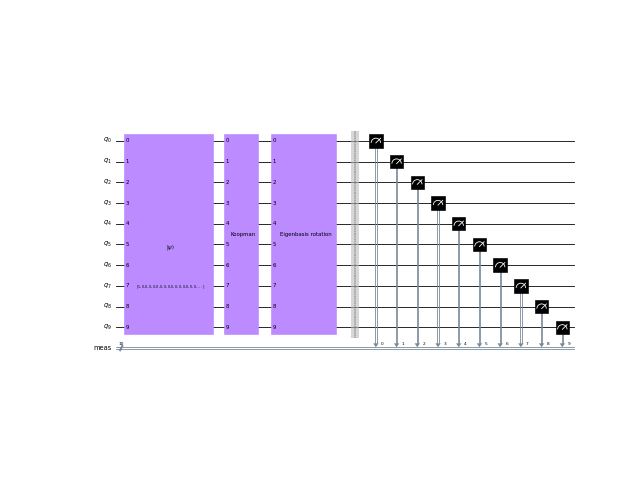

In [11]:
circ = koopman_circuit(q, m_evec, transfer_mat, xi)

i_fig = 1

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax.cla()
circ.draw(output='mpl', ax=ax)
circ.draw(output='latex_source', filename='koopman_circuit.tex');

In [12]:
j_ver = 150 # forecast verification timesetp
max_lead = 15
step_lead = 5

j_lead = np.arange(0, max_lead + 1, step_lead)
n_lead = len(j_lead)
y_true = y[j_ver - 1, 0]

In [13]:
predict_with_expectation = partial(pure_state_prediction, mat, m)

transfer_mats = iterate(mat, transfer_mat, initial=np.identity(n)) 
xis = (xi_da[j_ver - j] for j in j_lead)
exp_result = pl.starmap(predict_with_expectation, 
                        zip(islice(transfer_mats, 0, max_lead + 1, step_lead), 
                            xis))

In [14]:
n_shots = 1E6

make_circuit = partial(koopman_circuit, q, m_evec)
make_measurement = partial(ensemble_measurement, shots=n_shots)
predict_with_circuit = compose2(make_measurement, make_circuit)

transfer_mats = iterate(mat, transfer_mat, initial=np.identity(n)) 
xis = (xi_da[j_ver - j] for j in j_lead)
circ_pred = map(predict_with_circuit, 
                islice(transfer_mats, 0, max_lead + 1, step_lead), xis)
circ_result = take(n_lead, circ_pred)

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=3), Output()), _dom_cla…

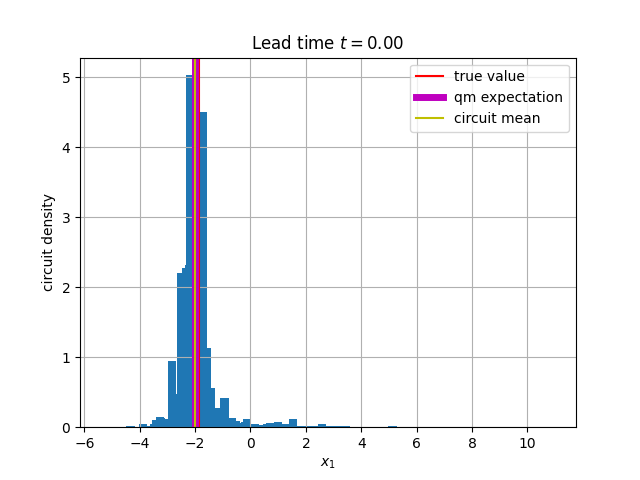

In [17]:
i_fig = 2

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)

i_slider = IntSlider(value=0, min=0, max=n_lead - 1, continuous_update=False)

@interact(i=i_slider) 
def plot_result(i):
    idx = circ_result[i][0]
    density = circ_result[i][1]
    density_dy = density / dy[idx]
    circ_mean = np.sum(m_eval[idx] * density)
    ax.cla()
    ax.axvline(x=y_true, color='r', label="true value")
    ax.axvline(x=exp_result[i], color='m', linewidth=5, label="qm expectation")
    ax.axvline(x=circ_mean, color='y', label="circuit mean")
    ax.bar(m_eval[idx], density_dy, width=0.3)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("circuit density")
    ax.set_title(f"Lead time $t={j_lead[i] * nlsa_model.dt:.2f}$")
    ax.legend()
    ax.grid()

-1.875209416074642
-1.9913476215865478
-1.0855136464682578
-0.38468786440103186
0.46968483427994445


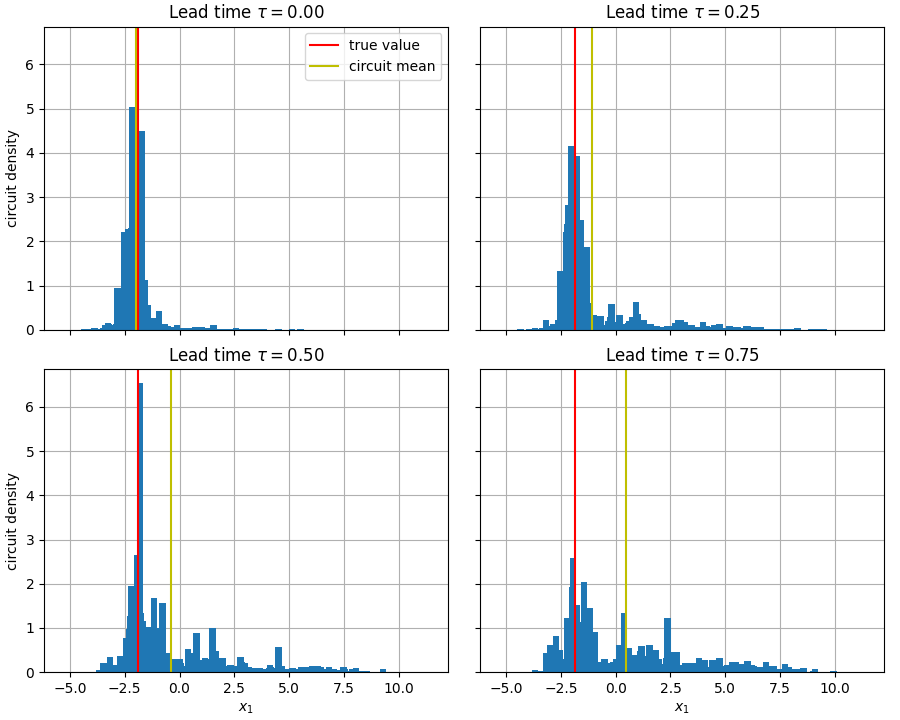

In [25]:
i_fig = 3

if plt.fignum_exists(i_fig):
    plt.close(i_fig)

fig, axs = plt.subplots(2, 2, figsize=(9, 7.2), subplot_kw=dict(box_aspect=0.75), 
                        num=i_fig, sharex=True, sharey=True,
                        constrained_layout=True)

print(y_true)
for i, ax in enumerate(axs.flatten()):
    idx = circ_result[i][0]
    density = circ_result[i][1]
    density_dy = density / dy[idx]
    circ_mean = np.sum(m_eval[idx] * density)
    print(circ_mean)
    ax.cla()
    ax.axvline(x=y_true, color='r', linewidth=1.5, label="true value")
    ax.axvline(x=circ_mean, color='y', linewidth=1.5, label="circuit mean")
    ax.bar(m_eval[idx], density_dy, width=0.3)
    ax.set_axisbelow(True)
    ax.set_title(f"Lead time $\\tau={j_lead[i] * nlsa_model.dt:.2f}$")
    ax.grid()
    
axs[0, 0].legend()

for ax in axs[:, 0]:
    ax.set_ylabel("circuit density")
    
for ax in axs[-1, :]:
    ax.set_xlabel("$x_1$")
    
plt.savefig('figCircuitPred.png', format='png', dpi=300)

In [32]:
fig, axs = plt.subplots(2, 2, num=i_fig, constrained_layout=True, sharex=True,
                        sharey=True)
axs[0]

array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

In [ ]:

pred = make_pure_state_prediction(mat, m) # maps xi -> float
preds = partial(map, pred) # maps [xi] -> [pred(xi)]
statevec_orb = partial(orbit, f=transfer_op) # maps xi -> [xi] (infinite orbit)
pred_orb = compose(preds, statevec_orb) # maps xi -> [pred(xi)] (infinite orbit)
pred_fin = compose(partial(take, n_pred), pred_orb) # maps xi -> first n elements of [pred(xi)]

y_da = pl.map(pred_fin, xi_da)

y_pred = np.array([y_da[j_ver - j][j] for j in range(n_lead)])